In [ ]:
from w2v import newsWord2Vec

w2v_skipgram = newsWord2Vec()
w2v_skipgram.load("vec_models/skipgram_model.bin")
w2v_skipgram.most_similar("thị trường")

[('rung lắc', 0.8926131725311279),
 ('thu hút', 0.8818274736404419),
 ('thống kê', 0.8818013668060303),
 ('hưng phấn', 0.8665414452552795),
 ('diễn biến', 0.8659288883209229),
 ('đồng thuận', 0.8627908825874329),
 ('hút', 0.8609051704406738),
 ('giảm giá', 0.8585386872291565),
 ('nhìn chung', 0.8572164177894592),
 ('đón', 0.8565258979797363)]

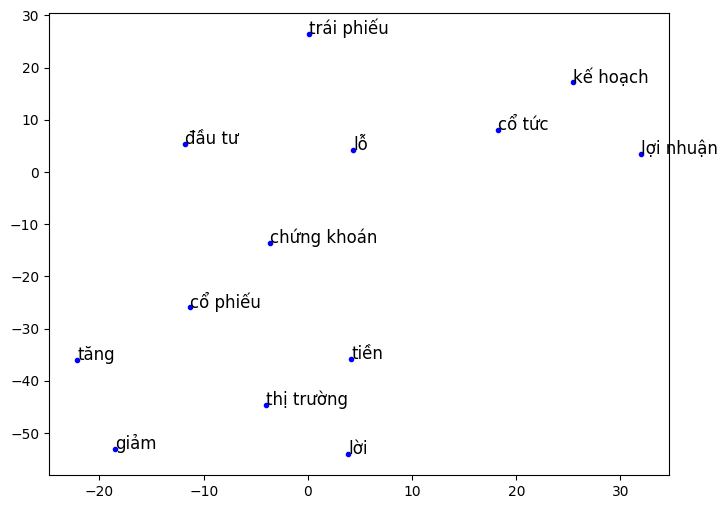

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Chọn các từ bạn muốn vẽ
selected_words = ["cổ phiếu", "cổ tức", "lợi nhuận", "chứng khoán", "tăng", "giảm",
                  "thị trường", "kế hoạch", "lời", "tiền", "trái phiếu", "lỗ", "đầu tư"]

# Lấy vector của các từ từ mô hình
vectors = np.array([w2v_skipgram.get_vector(word) for word in selected_words])

# Giảm chiều dữ liệu về 2 chiều bằng t-SNE
tsne = TSNE(n_components=2, perplexity=5 ,random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], marker='.', color='b')

# Hiển thị tên của các từ
for i, word in enumerate(selected_words):
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12)

plt.show()

In [ ]:
import pickle as pkl
words = dict()

for word in w2v_skipgram.get_vocab():
    words[word] = w2v_skipgram.get_vector(word)

with open("sentiment_analysis/words_dict.pkl", 'wb') as file:
    pkl.dump(words, file)

In [ ]:
with open("sentiment_analysis/words_dict.pkl", "rb") as file:
    words = pkl.load(file)

In [ ]:
from sentiment_analysis.preprocessing import processtext

def tokenize_vietnamese_sentence(sentence):
    return processtext(sentence.lower())

def sent2vec(message, word_dict = words):
    tokens = tokenize_vietnamese_sentence(message)
    vectors = []

    for token in tokens:
        if token not in word_dict.keys():
            continue
        token_vector = word_dict[token]
        vectors.append(token_vector)
    return np.array(vectors, dtype=float)

In [ ]:
import pandas as pd
from underthesea import sent_tokenize
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/stock_full.csv")
df = df.dropna()
df = df.reset_index(drop=True)

df.loc[df["label"]=='positive', 'label'] = 2
df.loc[df["label"]=='neutral', 'label'] = 1
df.loc[df["label"]=='negative', 'label'] = 0

X_train, X_temp, y_train, y_temp = train_test_split(df["content"], df["label"], test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_dev = X_dev.reset_index(drop=True)
y_dev = y_dev.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
def df_to_X_y(X):
    all_word_vector_sequences = []

    for message in X:
      message_as_vector_seq = sent2vec(message)
      if message_as_vector_seq.shape[0] == 0:
        message_as_vector_seq = np.zeros(shape=(1, 200))

      all_word_vector_sequences.append(message_as_vector_seq)

    return all_word_vector_sequences

In [ ]:
from copy import deepcopy

# Create sequences padding for X
def pad_sequences(X):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = 25 - x_seq_len
    if sequence_length_difference > 0:
      pad = np.zeros(shape=(sequence_length_difference, 200))
      X_copy[i] = np.concatenate([x, pad])
    else:
      X_copy[i] = x[0:25]

  return np.array(X_copy).astype(float)

In [ ]:
X_train = df_to_X_y(X_train)
X_train = pad_sequences(X_train)

X_train.shape

(2014, 25, 200)

(array([   0.,    0.,    0.,    0.,    0., 2014.,    0.,    0.,    0.,
           0.]),
 array([24.5, 24.6, 24.7, 24.8, 24.9, 25. , 25.1, 25.2, 25.3, 25.4, 25.5]),
 <BarContainer object of 10 artists>)

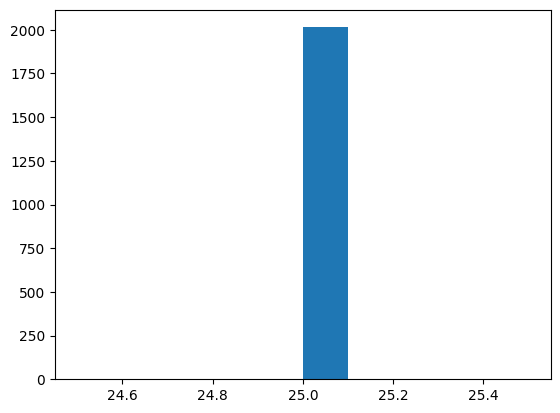

In [ ]:
import matplotlib.pyplot as plt

sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

plt.hist(sequence_lengths)

In [ ]:
X_dev = df_to_X_y(X_dev)
X_dev = pad_sequences(X_dev)

X_dev.shape

(252, 25, 200)

In [ ]:
X_test = df_to_X_y(X_test)
X_test = pad_sequences(X_test)

X_test.shape

(252, 25, 200)

In [ ]:
from keras import layers
from keras.models import Sequential

model = Sequential([])

model.add(layers.Input(shape=(25, 200)))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25, 128)        │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,675 (908.89 KB)

 Trainable params: 232,675 (908.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint(filepath='lstm_model/lstm_model.keras', save_best_only=True)

# Use the legacy Adam optimizer
optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
frequencies = pd.value_counts(y_train)

frequencies

C:\Users\x271890\AppData\Local\Temp\ipykernel_24076\3918391452.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  frequencies = pd.value_counts(y_train)


label
2    727
1    658
0    629
Name: count, dtype: int64

In [ ]:
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1], 2: frequencies.sum() / frequencies[2]}
weights

{0: 3.201907790143084, 1: 3.060790273556231, 2: 2.7702888583218708}

In [ ]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.int32)
X_dev = np.array(X_dev).astype(np.float32)
y_dev = np.array(y_dev).astype(np.int32)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=500, callbacks=[cp], class_weight=weights)

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.3563 - loss: 3.4659 - val_accuracy: 0.2897 - val_loss: 1.0982
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3846 - loss: 3.2722 - val_accuracy: 0.4683 - val_loss: 1.0485
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4423 - loss: 3.1511 - val_accuracy: 0.4683 - val_loss: 1.0015
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5133 - loss: 2.9597 - val_accuracy: 0.5992 - val_loss: 0.9142
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5958 - loss: 2.6999 - val_accuracy: 0.6071 - val_loss: 0.8464
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6463 - loss: 2.4438 - val_accuracy: 0.6984 - val_loss: 0.7619
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6922 - loss: 2.1677 - val_accuracy: 0.7262 - val_loss: 0.6797
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6888 - loss: 2.1576 - val_accuracy: 0

In [ ]:
from keras.models import load_model

# Assuming you have trained and saved your model as follows
model.save("lstm_model/lstm_model.h5")

---

## Classification Report

---

In [ ]:
test_predictions = (model.predict(X_test))
predicted_labels = np.argmax(test_predictions, axis=1)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.int32)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

print("Report: \n",classification_report(y_test,predicted_labels))
print("Confusion Matrix: \n",confusion_matrix(y_test,predicted_labels))
print("Accuracy: ",accuracy_score(y_test,predicted_labels))
print("Precision: ",precision_score(y_test,predicted_labels,average="weighted"))
print("Recall: ",recall_score(y_test,predicted_labels,average="weighted"))
print("F1-Score: ",f1_score(y_test,predicted_labels,average="weighted"))

Report: 
               precision    recall  f1-score   support

           0       0.71      0.64      0.67        86
           1       0.47      0.58      0.52        71
           2       0.74      0.67      0.70        95

    accuracy                           0.63       252
   macro avg       0.64      0.63      0.63       252
weighted avg       0.65      0.63      0.64       252

Confusion Matrix: 
 [[55 24  7]
 [14 41 16]
 [ 8 23 64]]
Accuracy:  0.6349206349206349
Precision:  0.6523538664856399
Recall:  0.6349206349206349
F1-Score:  0.6407394794856968


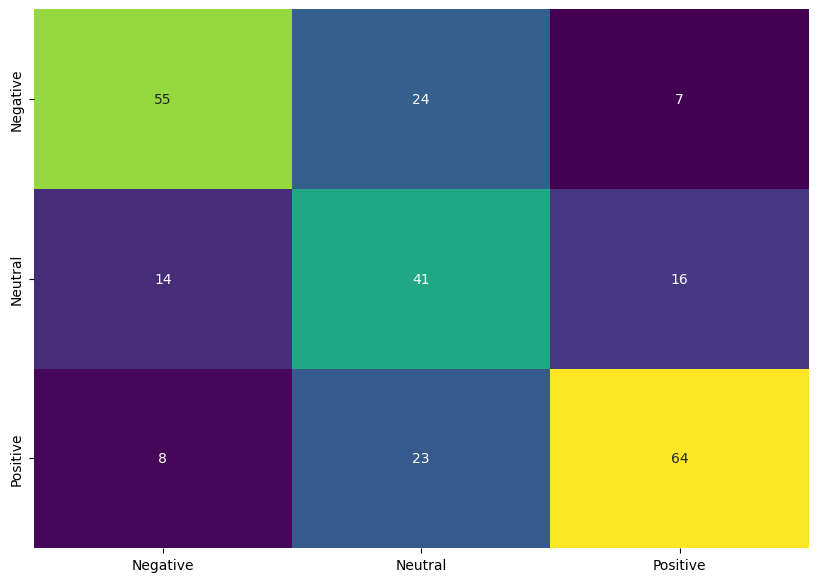

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test,predicted_labels)
plt.figure(figsize = (10,7))
sn.heatmap(conf_matrix, annot=True, fmt="d",cmap="viridis", cbar=False,
           xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.show()

---

## Prediction

---

In [ ]:
from keras.models import load_model
lstm_model = load_model("lstm_model/lstm_model.h5")
desired_sequence_length = 25

In [ ]:
def pad_sequence_sentence(sentence):
    array = sent2vec(sentence)
    arr_seq_len = array.shape[0]
    sequence_length_difference = desired_sequence_length - arr_seq_len

    pad = np.zeros(shape=(sequence_length_difference, 200))

    array = np.array(np.concatenate([array, pad]))
    array = np.expand_dims(array, axis=0)
    return array.astype(float)

In [ ]:
sentence = "Thị trường giảm mạnh sau khủng hoảng"
prediction = np.argmax(lstm_model.predict(pad_sequence_sentence(sentence)))
print("Sentiment: ", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
Sentiment:  0
